Import des bibliothèques et configuration MLflow

In [1]:
import sys
import mlflow
import mlflow.sklearn

# Définir l'URI de tracking.  On pointe vers le dossier mlruns du
# répertoire racine du projet (pas dans notebooks/) pour centraliser
# l'historique.
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("credit_scoring")

# Ajouter le chemin parent pour importer les modules du dossier src/
sys.path.append("..")

from src.data_prep import build_datasets, build_preprocessor
from src.metrics import compute_classic_metrics, business_cost, cost_curve

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split



C:\Users\Moham\anaconda3\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


Chargement des données

In [2]:
# Charger les jeux de données train et test (enrichis avec les
# agrégations bureau).  TARGET est uniquement dans train_df.
train_df, test_df = build_datasets()

X = train_df.drop(columns=["TARGET"])
y = train_df["TARGET"]

# Construction du préprocesseur (imputation + encodage one‑hot)
preprocessor = build_preprocessor(train_df)


Modèle baseline : régression logistique

Nous commençons par un modèle de base. La régression
logistique est simple et sert de référence. Le paramètre
class_weight="balanced" compense le fort déséquilibre de la cible
(≈ 92 % de clients solvables et 8 % en défaut).

In [3]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
)
# Pipeline = préprocessus + modèle
log_reg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg),
])
# Validation croisée stratifiée (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_scores = cross_val_score(
    log_reg_pipeline,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
)

print(f"AUC moyenne (régression logistique) : {log_scores.mean():.4f}")
print(f"Écart‑type AUC : {log_scores.std():.4f}")

# Enregistrement dans MLflow
with mlflow.start_run(run_name="logreg_baseline"):
    mlflow.log_param("model_type", "logistic_regression")
    mlflow.log_param("max_iter", log_reg.max_iter)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_metric("auc_mean", float(log_scores.mean()))
    mlflow.log_metric("auc_std", float(log_scores.std()))
    # On entraîne sur la totalité du dataset pour sauvegarder le modèle
    log_reg_pipeline.fit(X, y)
    mlflow.sklearn.log_model(log_reg_pipeline, "model")


AUC moyenne (régression logistique) : 0.6365
Écart‑type AUC : 0.0029


2025/12/13 22:03:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modèle avancé : Random Forest

La forêt aléatoire est un modèle d’arbres de décision assemblés. Elle gère bien les relations non linéaires et les interactions entre variables. Nous utilisons des paramètres de base : 200 arbres, pas de profondeur maximale fixée, et un poids de classe adapté au déséquilibre (balanced_subsample).

In [4]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42,
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_model),
])
# Validation croisée (5 folds)
rf_scores = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
)
print(f"AUC moyenne (Random Forest) : {rf_scores.mean():.4f}")
print(f"Écart‑type AUC : {rf_scores.std():.4f}")
# Logging MLflow pour la Random Forest
with mlflow.start_run(run_name="rf_baseline"):
    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("n_estimators", rf_model.n_estimators)
    mlflow.log_param("max_depth", rf_model.max_depth)
    mlflow.log_param("class_weight", "balanced_subsample")
    mlflow.log_metric("auc_mean", float(rf_scores.mean()))
    mlflow.log_metric("auc_std", float(rf_scores.std()))

    # Entraînement complet et sauvegarde
    rf_pipeline.fit(X, y)
    mlflow.sklearn.log_model(rf_pipeline, "model")

AUC moyenne (Random Forest) : 0.7332
Écart‑type AUC : 0.0029


2025/12/13 22:09:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Nous utilisons un jeu de validation pour ce calcul afin de ne pas
biaiser l’évaluation.

Seuil optimal : 0.10  —  coût moyen : 0.5528


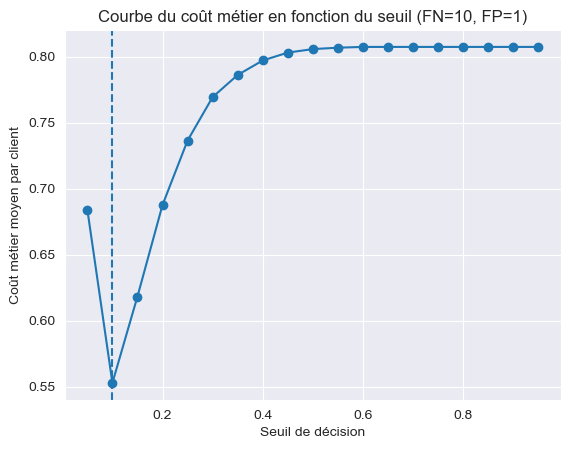

In [5]:
# Séparation train/validation (20 % de validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# Entraîner la Random Forest sur la partie train
rf_pipeline.fit(X_train, y_train)

# Probabilités de défaut sur le jeu de validation
y_valid_proba = rf_pipeline.predict_proba(X_valid)[:, 1]
# Calcul de la courbe coût / seuil (FN=10, FP=1)
thresholds, costs = cost_curve(
    y_valid,
    y_valid_proba,
    cost_fn=10.0,
    cost_fp=1.0,
    normalize=True,
)
# Seuil optimal = seuil minimisant le coût
best_idx = costs.argmin()
best_threshold = thresholds[best_idx]
best_cost = costs[best_idx]

print(f"Seuil optimal : {best_threshold:.2f}  —  coût moyen : {best_cost:.4f}")

# Sauvegarde du graphique coût vs seuil
plt.plot(thresholds, costs, marker="o")
plt.axvline(best_threshold, linestyle="--")
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier moyen par client")
plt.title("Courbe du coût métier en fonction du seuil (FN=10, FP=1)")

plot_path = "../reports/figures/courbe_cout_vs_seuil.png"
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

# Log de la figure dans MLflow
with mlflow.start_run(run_name="rf_cost_curve"):
    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("business_cost_fn", 10.0)
    mlflow.log_param("business_cost_fp", 1.0)
    mlflow.log_metric("best_threshold", float(best_threshold))
    mlflow.log_metric("best_cost", float(best_cost))
    mlflow.log_artifact(plot_path, artifact_path="figures")

Pour bien comprendre l’effet du seuil, nous comparons les métriques
classiques et le coût métier pour la valeur par défaut 0,5 et pour le
seuil optimal trouvé précédemment (0,10 environ).

In [6]:
# Seuil par défaut 0,5
metrics_05 = compute_classic_metrics(y_valid, y_valid_proba, threshold=0.5)
cost_05, conf_05 = business_cost(y_valid, y_valid_proba, threshold=0.5)

# Seuil optimisé (~0,10)
metrics_opt = compute_classic_metrics(y_valid, y_valid_proba, threshold=best_threshold)
cost_opt, conf_opt = business_cost(y_valid, y_valid_proba, threshold=best_threshold)

print("\nSeuil 0,5 :")
print(metrics_05)
print(f"Coût moyen : {cost_05:.4f}")
print(f"Confusion matrix : {conf_05}")

print("\nSeuil optimisé :")
print(metrics_opt)
print(f"Coût moyen : {cost_opt:.4f}")
print(f"Confusion matrix : {conf_opt}")


Seuil 0,5 :
{'auc': np.float64(0.7366507877117965), 'precision': 0.55, 'recall': 0.002215508559919436, 'f1': 0.0044132397191574725}
Coût moyen : 0.8056
Confusion matrix : {'tn': np.int64(56529), 'fp': np.int64(9), 'fn': np.int64(4954), 'tp': np.int64(11)}

Seuil optimisé :
{'auc': np.float64(0.7366507877117965), 'precision': 0.17518507551080842, 'recall': 0.5957703927492447, 'f1': 0.27075514874141876}
Coût moyen : 0.5528
Confusion matrix : {'tn': np.int64(42611), 'fp': np.int64(13927), 'fn': np.int64(2007), 'tp': np.int64(2958)}


Entraînement et export du modèle final

In [7]:
# Entraîner sur l’ensemble de train_df
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42,
)

final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_final),
])

final_pipeline.fit(X, y)

FINAL_THRESHOLD = best_threshold

with mlflow.start_run(run_name="rf_final_model"):
    # Journalisation des hyperparamètres du modèle final
    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("n_estimators", rf_final.n_estimators)
    mlflow.log_param("max_depth", rf_final.max_depth)
    mlflow.log_param("class_weight", "balanced_subsample")
    mlflow.log_param("business_threshold", FINAL_THRESHOLD)

    # Évaluer la performance en validation croisée pour la robustesse
    final_cv_scores = cross_val_score(
        final_pipeline,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=1,
    )
    mlflow.log_metric("final_auc_mean", float(final_cv_scores.mean()))
    mlflow.log_metric("final_auc_std", float(final_cv_scores.std()))

    # Coût sur le train complet avec le seuil final
    y_train_proba = final_pipeline.predict_proba(X)[:, 1]
    train_cost, _ = business_cost(y, y_train_proba, threshold=FINAL_THRESHOLD)
    mlflow.log_metric("train_business_cost", float(train_cost))

    # Sauvegarder le modèle dans MLflow (artifacts) et exporter dans model/
    mlflow.sklearn.log_model(final_pipeline, "model")
    mlflow.sklearn.save_model(final_pipeline, "../model")

print(f"Modèle final exporté dans le dossier model/ avec seuil {FINAL_THRESHOLD:.2f}")

2025/12/13 22:18:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MlflowException: Path '../model' already exists and is not empty

In [8]:
# À exécuter une seule fois dans l'environnement
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 11.3 MB/s  0:00:00


In [9]:
from lightgbm import LGBMClassifier